In [21]:
from mpl_toolkits.mplot3d import axes3d # 3D figure
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import math
import scipy.interpolate as interpolate
import scipy.signal as signal
from scipy.optimize import curve_fit

from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as tck
import scipy.io as sio
import pandas as pd
import matplotlib.ticker as ticker

import os

from pylab import *
from numpy import *
from matplotlib.widgets import Button
from matplotlib import rc

import glob
import csv
params={'axes.labelsize':20,'xtick.labelsize':15,'ytick.labelsize':15}
rcParams.update(params)

In [22]:
# Colour Palette
rcParams["axes.prop_cycle"]=cycler(color=['#68246D', '#FFD53A', '#00AEEF', '#BE1E2D', '#AFA961'])

## Load data

### With pandas

In [23]:


# # Load data
# # Port 1, i.e. reference cell
# data1 = pd.read_csv('Data/elecsus_cells_66C1_1.csv')
# # Port 4, i.e. natural abundance cell
# data4 = pd.read_csv('Data/elecsus_cells_66C1_4.csv')

# # Drop first row
# data1 = data1.drop(0)
# data4 = data4.drop(0)

# # Rename columns
# data1.columns = ['Time', 'Voltage']
# data4.columns = ['Time', 'Voltage']

# data1 = data1.astype(float)
# data4 = data4.astype(float)

# # Drop index
# data1 = data1.reset_index(drop=True)
# data4 = data4.reset_index(drop=True)


### Without pandas

#### PBS data

In [24]:
power_on_ref_cell = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 150, 200])

power = 1

Rb_spectrum_reference = np.loadtxt(f'Data/Power sweep with PBS reference cell/abs_ref_{power}uW_1.csv', delimiter=',', skiprows=2)




#### Temperature sweep memory cell

In [25]:
# First data, T = 66
# Rb_spectrum_memory = np.loadtxt('Data/elecsus_cells_66C1_1.csv', delimiter=',', skiprows=2)
# Rb_spectrum_reference = np.loadtxt('Data/elecsus_cells_66C1_4.csv', delimiter=',', skiprows=2)

# Measurement for varying temp

# T = 24
# Rb_spectrum_memory = np.loadtxt('Data/elecsus_abs_spec_24_1.csv', delimiter=',', skiprows=2)
# Rb_spectrum_reference = np.loadtxt('Data/elecsus_abs_spec_24_4.csv', delimiter=',', skiprows=2)


#### Durham data

In [26]:
# Durham data
# Rb_spectrum_memory = np.loadtxt('Data/Dopp_Broadened_20C.csv', delimiter=',', skiprows=2)
# Rb_spectrum_reference = np.loadtxt('Data/Dopp_Broadened_20C.csv', delimiter=',', skiprows=1, dtype='float')






## First overview

In [27]:
down_scan = False

Time = Rb_spectrum_reference[:,0]

print('Data set length:', len(Time))

Data set length: 9216


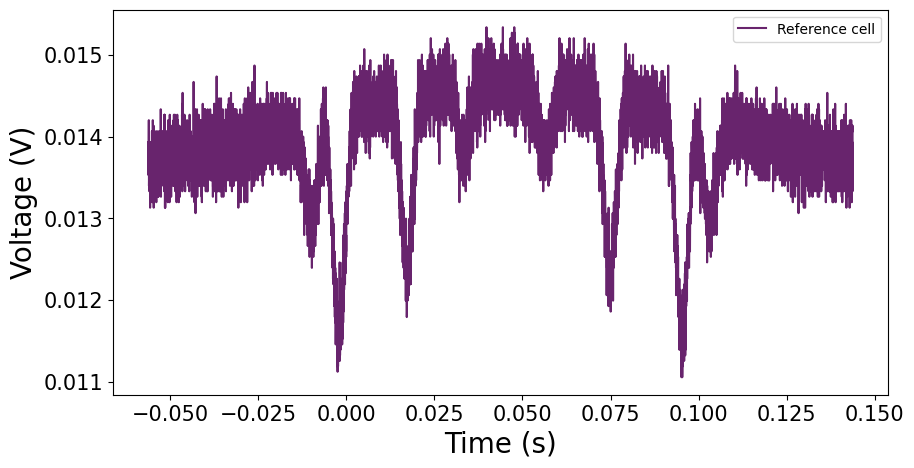

In [28]:
# Plot data
plt.figure(figsize=(10,5))
# plt.plot(Rb_spectrum_memory[:,0], Rb_spectrum_memory[:,1], label='Memory cell')
plt.plot(Time, Rb_spectrum_reference[:,1], label='Reference cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

## Crop data (up scan)

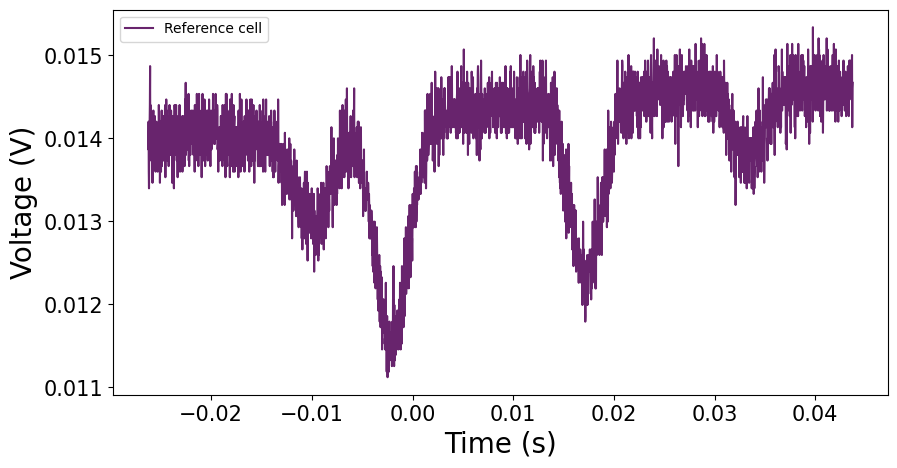

In [29]:
# Crop data
crop_start = int(15/100 * len(Time))
crop_end = int(50/100 * len(Time))

# Rb_spectrum_memory_cropped = Rb_spectrum_memory[crop_start:crop_end]
Rb_spectrum_reference_cropped = Rb_spectrum_reference[crop_start:crop_end]

# Plot data
plt.figure(figsize=(10,5))
# plt.plot(Rb_spectrum_memory_cropped[:,0], Rb_spectrum_memory_cropped[:,1], label='Memory cell')
plt.plot(Rb_spectrum_reference_cropped[:,0], Rb_spectrum_reference_cropped[:,1], label='Reference cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

## Crop data (down scan)

In [30]:
if down_scan:    
    # Crop data
    crop_start = 55000
    crop_end = len(Rb_spectrum_memory)

    Rb_spectrum_memory_cropped = Rb_spectrum_memory[crop_start:crop_end]
    Rb_spectrum_reference_cropped = Rb_spectrum_reference[crop_start:crop_end]

    # Plot data
    plt.figure(figsize=(10,5))
    plt.plot(Rb_spectrum_memory_cropped[:,0], Rb_spectrum_memory_cropped[:,1], label='Memory cell')
    plt.plot(Rb_spectrum_reference_cropped[:,0], Rb_spectrum_reference_cropped[:,1], label='Reference cell')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.show()

## Time axis

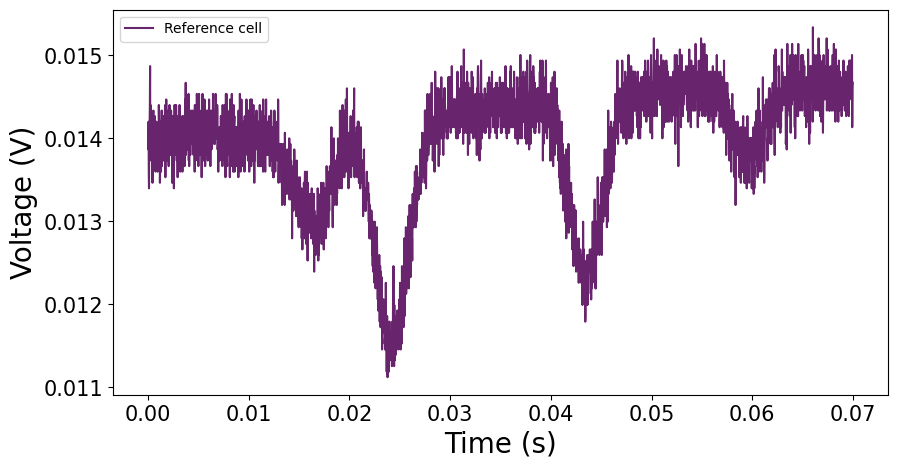

In [31]:
# Shorten raw data
Time_cropped = Rb_spectrum_reference_cropped[:,0]
Time_cropped = Time_cropped-Time_cropped[0] #Set first data to be at t=0ms

# Plot data
plt.figure(figsize=(10,5))
# plt.plot(Time_cropped, Rb_spectrum_memory_cropped[:,1], label='Memory cell')
plt.plot(Time_cropped, Rb_spectrum_reference_cropped[:,1], label='Reference cell')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


## Convert time to frequency for reference data

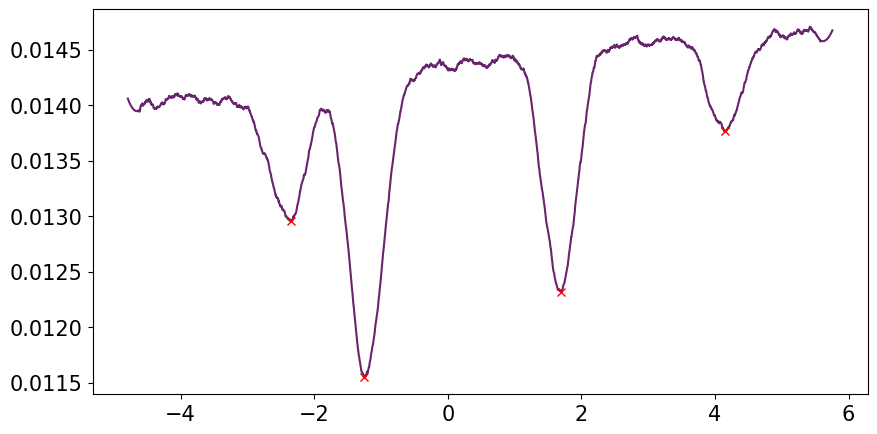

In [32]:
# Convert to frequency space
_Rb87F1 = 4.15; _Rb85F2 = 1.675; _Rb85F3 = -1.232; _Rb87F2 = -2.366


if down_scan:
    freq_Rb = np.array([_Rb87F1, _Rb85F2, _Rb85F3, _Rb87F2])
if down_scan == False:
    freq_Rb = np.array([_Rb87F2, _Rb85F3, _Rb85F2, _Rb87F1])



# Smoothen data before finding dips
Rb_spectrum_reference_smooth = signal.savgol_filter(Rb_spectrum_reference_cropped[:,1], 100, 2)

if down_scan:
    Rb_spectrum_reference_smooth = np.flip(Rb_spectrum_reference_smooth)


# Find the dips in the reference cell data 
dips_reference, _ = signal.find_peaks(-Rb_spectrum_reference_smooth, prominence = 0.0005, distance=100)

# Linear fit to the dips
freq_array = np.polyval(np.polyfit(dips_reference, freq_Rb, 2), np.linspace(0, len(Rb_spectrum_reference_smooth), len(Rb_spectrum_reference_smooth)))


if down_scan: 
    freq_array = np.flip(freq_array)
    


# Plot dips
plt.figure(figsize=(10,5))
# plt.plot(Time_cropped, Rb_spectrum_reference_smooth)
# plt.plot(Time_cropped[dips_reference], Rb_spectrum_reference_smooth[dips_reference], 'x', label='Dips', color='red')
plt.plot(freq_array, Rb_spectrum_reference_smooth, label='Reference cell')
plt.plot(freq_array[dips_reference], Rb_spectrum_reference_smooth[dips_reference], 'x', label='Dips', color='red')
plt.show()


## Define regions of non-absorption for reference

### Up scan

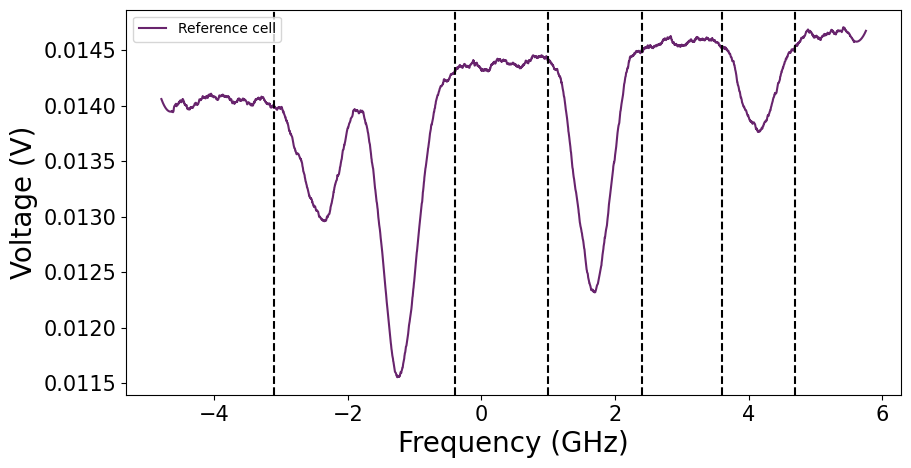

In [33]:

# Define transmission regions
point_A = np.where(freq_array > -3.1)[0][0]
point_B = np.where(freq_array > -0.4)[0][0]
point_C = np.where(freq_array > 1)[0][0]
point_D = np.where(freq_array > 2.4)[0][0]
point_E = np.where(freq_array > 3.6)[0][0]
point_F = np.where(freq_array > 4.7)[0][0]

# Plot with points
plt.figure(figsize=(10, 5))
plt.plot(freq_array, Rb_spectrum_reference_smooth, label='Reference cell')
# plt.plot(freq_array, Rb_spectrum_memory_cropped[:, 1], label='Memory cell')
plt.axvline(x=freq_array[point_A], color='k', linestyle='--')
plt.axvline(x=freq_array[point_B], color='k', linestyle='--')
plt.axvline(x=freq_array[point_C], color='k', linestyle='--')
plt.axvline(x=freq_array[point_D], color='k', linestyle='--')
plt.axvline(x=freq_array[point_E], color='k', linestyle='--')
plt.axvline(x=freq_array[point_F], color='k', linestyle='--')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

### Down scan

In [34]:
if down_scan:
    # Define transmission regions
    point_A = np.where(freq_array > -5.1)[0][0]
    point_B = np.where(freq_array > -2.5)[0][0]
    point_C = np.where(freq_array > -1.3)[0][0]
    point_D = np.where(freq_array > 0.2)[0][0]
    point_E = np.where(freq_array > 1.4)[0][0]
    point_F = np.where(freq_array > 2.6)[0][0]



    # Plot with points
    plt.figure(figsize=(10, 5))
    plt.plot(freq_array, Rb_spectrum_reference_smooth, label='Reference cell')
    plt.axvline(x=freq_array[point_A], color='k', linestyle='--')
    plt.axvline(x=freq_array[point_B], color='k', linestyle='--')
    plt.axvline(x=freq_array[point_C], color='k', linestyle='--')
    plt.axvline(x=freq_array[point_D], color='k', linestyle='--')
    plt.axvline(x=freq_array[point_E], color='k', linestyle='--')
    plt.axvline(x=freq_array[point_F], color='k', linestyle='--')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.show()

## Fit regions of non-absorption to get normalisation

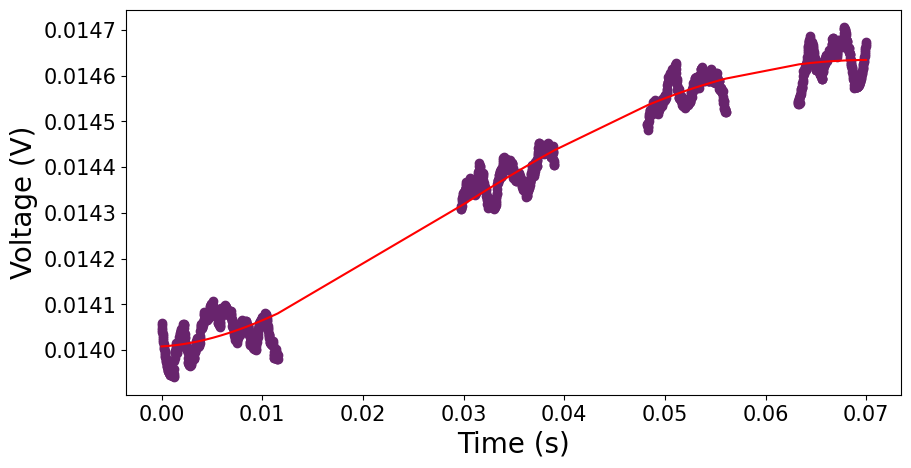

In [35]:
# Take data corresponding to off-resonant frequencies for reference

transmission_a_reference = Rb_spectrum_reference_smooth[:point_A,]
transmission_b_to_c_reference = Rb_spectrum_reference_smooth[point_B:point_C]
transmission_d_to_e_reference = Rb_spectrum_reference_smooth[point_D:point_E]
transmission_f_reference = Rb_spectrum_reference_smooth[point_F:]


off_resonant_time_reference = np.concatenate([Time_cropped[:point_A], Time_cropped[point_B:point_C], Time_cropped[point_D:point_E], Time_cropped[point_F:]])

# off_resonant_transmission_reference_section1 = np.concatenate([transmission_a_reference, transmission_b_to_c_reference])
# off_resonant_transmission_reference_section2 = np.concatenate([transmission_d_to_e_reference, transmission_f_reference])
off_resonant_transmission_reference = np.concatenate([Rb_spectrum_reference_smooth[:point_A], Rb_spectrum_reference_smooth[point_B:point_C], Rb_spectrum_reference_smooth[point_D:point_E], Rb_spectrum_reference_smooth[point_F:]])
# off_resonant_transmission_reference = np.concatenate([Rb_spectrum_reference_cropped[:point_A, 1], Rb_spectrum_reference_cropped[point_B:point_C, 1], Rb_spectrum_reference_cropped[point_D:point_E, 1], Rb_spectrum_reference_cropped[point_F:, 1]])



# Apply polyfit to off resonant data
# p_reference_section1 = np.polyfit(off_resonant_time_reference_section1, off_resonant_transmission_reference_section1, 3)
# p_reference_section2 = np.polyfit(off_resonant_time_reference_section2, off_resonant_transmission_reference_section2, 3)
p_reference = np.polyfit(off_resonant_time_reference, off_resonant_transmission_reference, 4)


# Plot polyfit
plt.figure(figsize=(10, 5))
plt.scatter(off_resonant_time_reference, off_resonant_transmission_reference)
plt.plot(off_resonant_time_reference, np.polyval(p_reference, off_resonant_time_reference), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()





## Normalisation

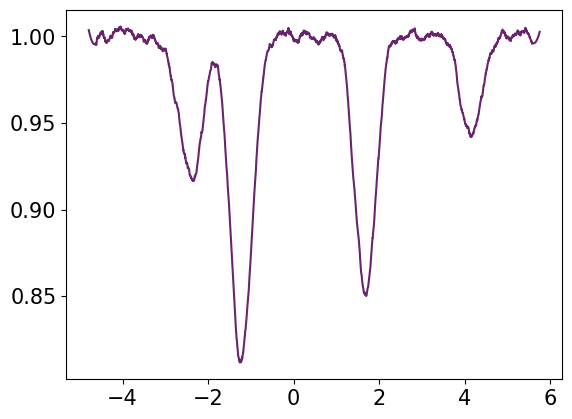

In [36]:
# Normalize the data with the polyfit
Rb_spectrum_reference_norm = Rb_spectrum_reference_smooth[:]/np.polyval(p_reference, Time_cropped)


plt.plot(freq_array, Rb_spectrum_reference_norm)

plt.show()



# Save to csv with first column as frequency and second column as transmission
# np.savetxt('Data/elecsus_cells_66C1_1_normalised.csv', np.column_stack((freq_array, Rb_spectrum_memory_norm)), delimiter=',')
# np.savetxt('Data/elecsus_cells_66C1_4_normalised.csv', np.column_stack((freq_array, Rb_spectrum_reference_norm)), delimiter=',')

## Get detuning of dips from transitions

Dips located at:  [-2.34832822 -1.25890395  1.69401505  4.14699477]
Detuning from D2 line frequencies in MHz: [ 17.67178255 -26.90395216  19.01504738  -3.00523336]
Total detuning in MHz: 37.50623941548104
Ratio of Rb 85 dips: 1.2570465940181286


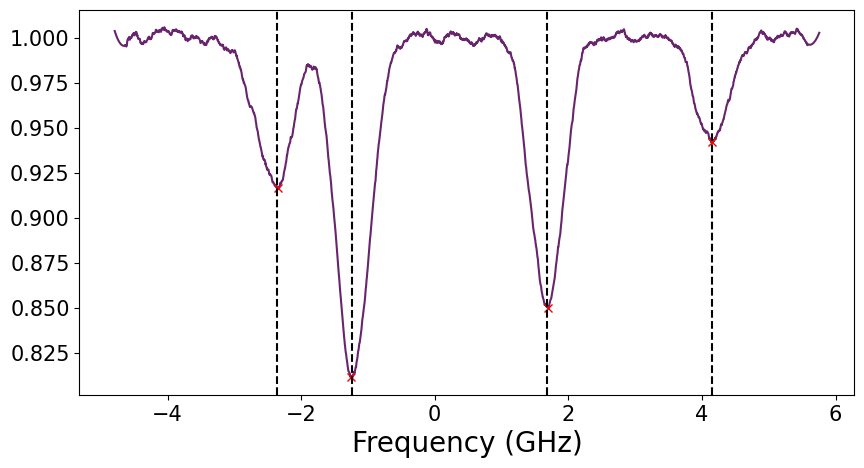

In [37]:
# data_memory = np.column_stack((freq_array, Rb_spectrum_memory_smooth))
# data_reference = np.column_stack((freq_array, Rb_spectrum_reference_smooth))

# # Save to csv with first column as frequency and second column as transmission
# np.savetxt('Data/elecsus_cells_66C1_1_normalised.csv', data_memory, delimiter=',')
# np.savetxt('Data/elecsus_cells_66C1_4_normalised.csv', data_reference, delimiter=',')

dips, _ = signal.find_peaks(-Rb_spectrum_reference_norm, prominence = 0.03)

# Plot data with dips
plt.figure(figsize=(10, 5))
# plt.plot(Time_cropped, Rb_spectrum_reference_norm)
# plt.plot(Time_cropped[dips], Rb_spectrum_reference_norm[dips], 'x', color='red')

plt.plot(freq_array, Rb_spectrum_reference_norm, label='Reference cell')
plt.plot(freq_array[dips], Rb_spectrum_reference_norm[dips], 'x', color='red')
plt.axvline(freq_Rb[0], color='k', linestyle='--')
plt.axvline(freq_Rb[1], color='k', linestyle='--')
plt.axvline(freq_Rb[2], color='k', linestyle='--')
plt.axvline(freq_Rb[3], color='k', linestyle='--')
plt.xlabel('Frequency (GHz)')


print('Dips located at: ', freq_array[dips])

detunings = freq_array[dips] - freq_Rb
total_detuning = norm(detunings)


print('Detuning from D2 line frequencies in MHz:', detunings*1e3)
print('Total detuning in MHz:', total_detuning*1e3)

# Get ratio of depth of dips
Rb85_F3_dip = 1-Rb_spectrum_reference_norm[dips[1]]
Rb85_F2_dip = 1-Rb_spectrum_reference_norm[dips[2]]

ratio_Rb85_dips = Rb85_F3_dip/Rb85_F2_dip

print('Ratio of Rb 85 dips:', ratio_Rb85_dips)







## Zero the dips for memory data

In [38]:
# # Zero the dips
# Rb_spectrum_memory_smooth[np.where(Rb_spectrum_memory_smooth <= 0)] = 0

# plt.plot(freq_array_smooth, Rb_spectrum_memory_smooth)
# plt.show()

In [39]:
np.ones(8)

array([1., 1., 1., 1., 1., 1., 1., 1.])

## Fit ElecSus to reference cell

In [40]:
# Fit ElecSus

import ElecSus_PQI.elecsus.elecsus_methods as EM

# Horizontal polarization
E_in=np.array([0,1,0])
E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
E_in=E_in_angle

# Cicular polarisation
# phase = np.pi
# E_in=np.array([1,1,0])
# E_in = [E_in[0], E_in[1]*np.exp(1.j*phase)]
# E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
# E_in = E_in_angle

groundPop = 0


# Initial values
p_dict_1 = {'Elem':'Rb','Dline':'D2','T':20,'lcell':75e-3, 'shift':0, 'Btheta':0,'Bfield':0,
            'shift':0,'Bphi':0,'GammaBuf':0, 'DoppTemp': 20, 'rb85frac': 0, 'Constrain':True}
p_dict_guess=p_dict_1

p_dict_bools={'T':True, 'DoppTemp':False, 'rb85frac': False, 'shift':True}

p_dict_bounds={}
p_dict_bounds['shift']=(-10, 10)
# p_dict_bounds['rb85frac']=(60, 85)
p_dict_bounds['T']=(0, 30)
# p_dict_bounds['DoppTemp']=(0, 40)



# Fit
best_params, RMS, result = EM.fit_data([freq_array*1e3, Rb_spectrum_reference_norm], p_dict_guess, p_dict_bools, groundPop,
                                       E_in, p_dict_bounds, data_type='S0',fit_algorithm='ML')

report = result.fit_report()
elecsus_fit = result.best_fit
print(report)


Starting parameter dictionary:
 {'Elem': 'Rb', 'Dline': 'D2', 'T': 20, 'lcell': 0.075, 'shift': 0, 'Btheta': 0, 'Bfield': 0, 'Bphi': 0, 'GammaBuf': 0, 'DoppTemp': 20, 'rb85frac': 0, 'Constrain': True}

Perfoming Marquardt-Levenberg fitting routine.
Parameters([('E_x', <Parameter 'E_x', value=-inf, bounds=[-inf:inf]>), ('E_y', <Parameter 'E_y', value=-inf, bounds=[-inf:inf]>), ('E_phase', <Parameter 'E_phase', value=-inf, bounds=[-inf:inf]>), ('T', <Parameter 'T', value=20, bounds=[-inf:inf]>), ('lcell', <Parameter 'lcell', value=0.075, bounds=[-inf:inf]>), ('Bfield', <Parameter 'Bfield', value=0, bounds=[-inf:inf]>), ('Btheta', <Parameter 'Btheta', value=0, bounds=[-inf:inf]>), ('Bphi', <Parameter 'Bphi', value=0, bounds=[-inf:inf]>), ('GammaBuf', <Parameter 'GammaBuf', value=0, bounds=[-inf:inf]>), ('shift', <Parameter 'shift', value=0, bounds=[-inf:inf]>), ('groundPop', <Parameter 'groundPop', value=-inf, bounds=[-inf:inf]>), ('DoppTemp', <Parameter 'DoppTemp', value=20, bounds=[-inf

Text(0, 0.5, 'Residuals (%)')

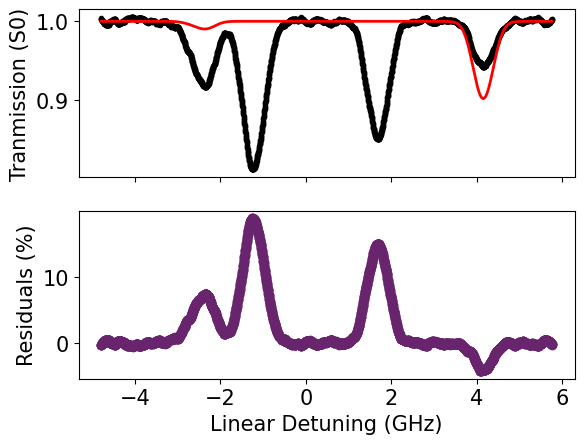

In [22]:
# dips_elecsus, _ = signal.find_peaks(-elecsus_fit, prominence = 0.03)

# # Get ratio of depth of dips
# Rb85_F3_dip_elecsus = 1-elecsus_fit[dips_elecsus[1]]
# Rb85_F2_dip_elecsus = 1-elecsus_fit[dips_elecsus[2]]

# ratio_Rb85_dips_elecsus = Rb85_F3_dip_elecsus/Rb85_F2_dip_elecsus

# print('Ratio of Rb 85 dips elecsus fit:', ratio_Rb85_dips_elecsus)
# print('Ratio of Rb 85 dips:', ratio_Rb85_dips)

fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(freq_array,Rb_spectrum_reference_norm,'k.',label='Data')
# ax[0].plot(freq_array[dips_elecsus],elecsus_fit[dips_elecsus],'x', color='blue',label='Dips')
ax[0].plot(freq_array,elecsus_fit,'r-',lw=2,label='Fit')
ax[0].set_ylabel('Tranmission (S0)', fontsize=15)
ax[1].set_xlabel('Linear Detuning (GHz)', fontsize=15)
ax[1].scatter(freq_array,100*(elecsus_fit-((Rb_spectrum_reference_norm))))
ax[1].set_ylabel('Residuals (%)', fontsize=15)

In [284]:
# ratio_Rb85_dips_list = np.zeros(len(power_on_ref_cell))
# ratio_Rb85_dips_elecsus_list = np.zeros(len(power_on_ref_cell))
# R_sq_list = np.zeros(len(power_on_ref_cell))
# temperature_elecsus = np.zeros(len(power_on_ref_cell))
# Rb85_fraction_list = np.zeros(len(power_on_ref_cell))

### Fit performance for power sweep PBS

In [285]:




# ratio_Rb85_dips = [1.257, 1.261, 1.259, 1.508, 1.970, 2.356, 2.582, 2.755]
ratio_Rb85_dips_list[np.where(power_on_ref_cell==power)] = ratio_Rb85_dips

# ratio_Rb85_dips_elecsus = [1.319, 1.299, 1.306, 1.316, 1.301, 1.307, 1.313,  1.317]
ratio_Rb85_dips_elecsus_list[np.where(power_on_ref_cell==power)] = ratio_Rb85_dips_elecsus

# R_sq = [0.993, 0.989, 0.991, 0.985, 0.951, 0.917, 0.901, 0.889]
R_sq_list[np.where(power_on_ref_cell==power)] = result.rsquared

temperature_elecsus[np.where(power_on_ref_cell==power)] = best_params['T']

Rb85_fraction_list[np.where(power_on_ref_cell==power)] = best_params['rb85frac']








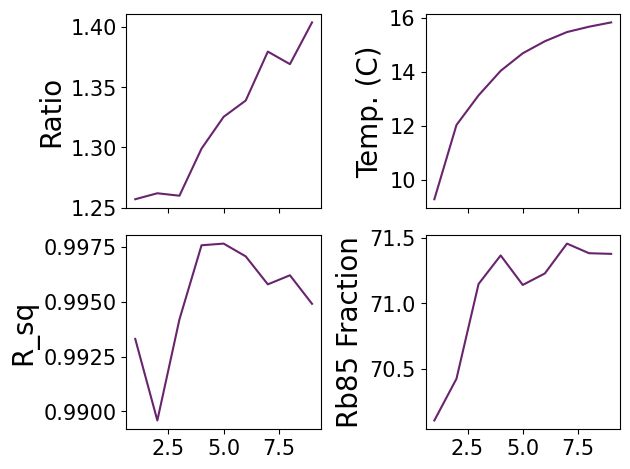

In [292]:
# Plot ratio and R_sq as function of power

small_power = np.where(power_on_ref_cell == [1, 2, 3, 4, 5, 6, 7, 8, 9])

# Plot only for small power


fig, ax = plt.subplots(2, 2, sharex = True)
ax[0][0].plot(power_on_ref_cell[0:9], ratio_Rb85_dips_list[0:9], label='Ratio Rb85 Dips')
ax[0][0].set_ylabel('Ratio')

ax[1][0].plot(power_on_ref_cell[0:9], R_sq_list[0:9], label='R_sq')
ax[1][0].set_ylabel('R_sq')

ax[0][1].plot(power_on_ref_cell[0:9], temperature_elecsus[0:9])
ax[0][1].set_ylabel('Temp. (C)')

ax[1][1].plot(power_on_ref_cell[0:9], Rb85_fraction_list[0:9])
ax[1][1].set_ylabel('Rb85 Fraction')

plt.tight_layout()

plt.show()